In [18]:
# Data imports
import pandas as pd
import numpy as np

# Visualization imports
import plotly.express as px
import matplotlib.pyplot as plt

# ML Imports and configuration
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import set_config
from sklearn.metrics import confusion_matrix
set_config(display="diagram")
pd.set_option('display.width', 190)


### 1. Import the Data

The first step in any ML workflow is to get the data and explore it

In [19]:
data = pd.read_csv("hotel_bookings.csv")
size_raw = data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### Data Cleaning
Next, we do some basic cleanup. I this case we perform the following:
1. Check for bad data (columns) and remove them
2. Check for outliers and remove them
3. Remove highly correlated variables

In [20]:
#Check for columns that can be deleted, based on missing values
missing = (data.isna().sum() /size_raw[0])

print(missing[missing > 0])

children    0.000034
country     0.004087
agent       0.136862
company     0.943069
dtype: float64


In [21]:
#Remove the ones with very high missing ratio (Just "agent" in this case)
data.drop('company',axis=1, inplace = True)

In [22]:
# There is a 1 to 1 mapping between is_cancelled and reservation_status. This is definitely cheating, so we will remove this
data.drop('reservation_status',axis=1, inplace = True)

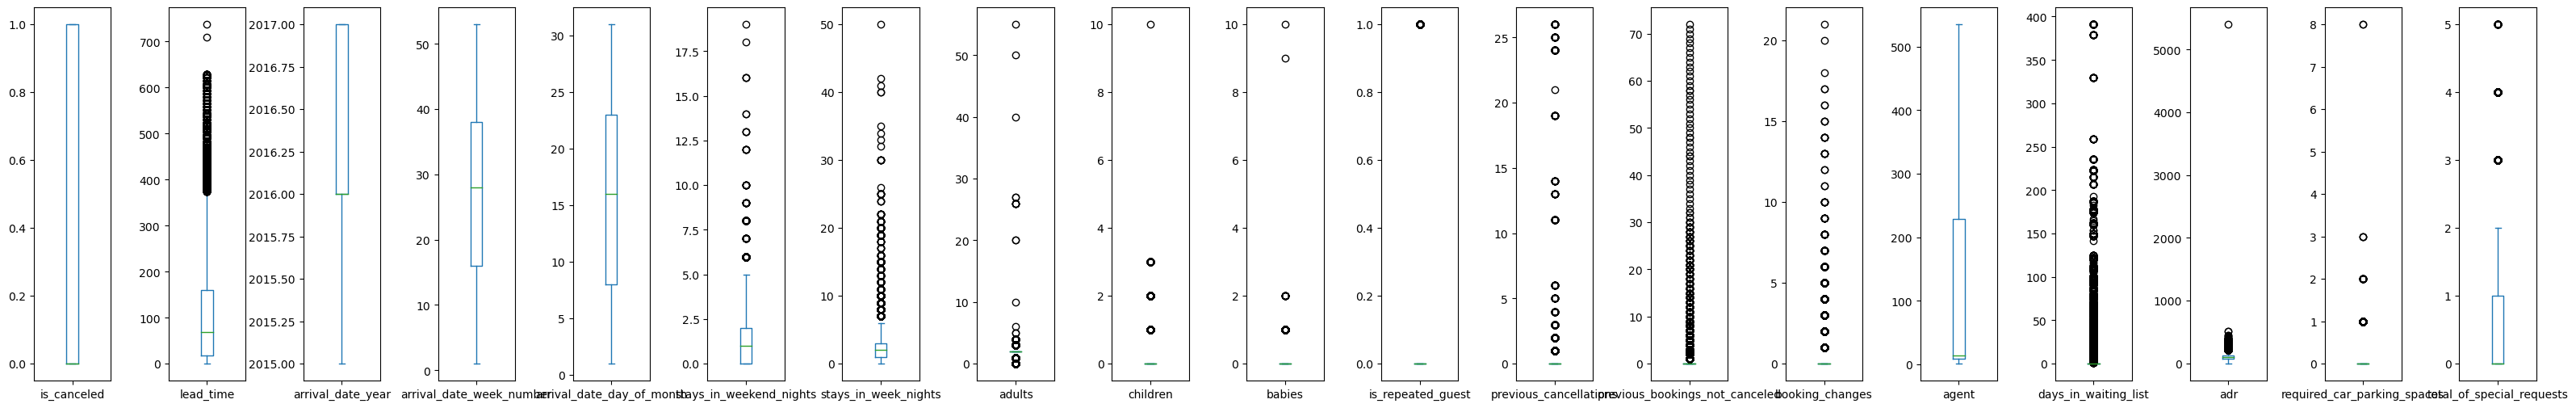

In [23]:
# Check for outliers Visually
data.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(40, 6)
)
plt.subplots_adjust(wspace=.75) 

In [24]:
# Remove the obvious outliers manually per column. We could be a lot more formal with something like Grubb's Test, but this works fine for now.

#Start with the most obvious, replace values with visual maximum
data.loc[data.adr > 600,'adr']= 600
data.loc[data.lead_time > 650,'lead_time']= 650
data.loc[data.required_car_parking_spaces > 3,'required_car_parking_spaces']= 3
data.loc[data.adults > 10,'adults']= 10
data.loc[data.children > 3,'children']= 3
data.loc[data.babies > 3,'babies']= 3

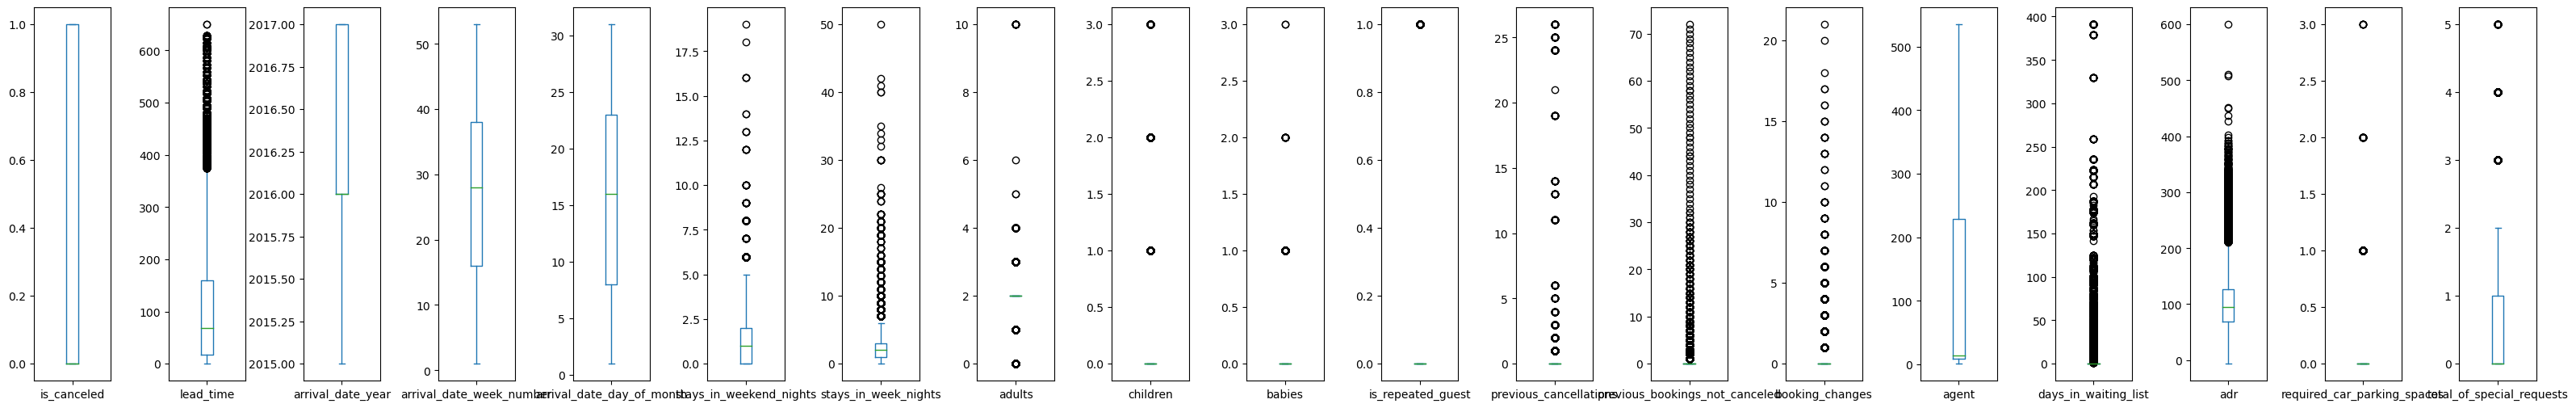

In [25]:
# Recheck until data looks good. At this point just looking for nice Distributions with no huge tails
data.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(40, 6)
)
plt.subplots_adjust(wspace=.75) 

In [26]:
# Remove Duplictes
data.drop_duplicates(inplace=True)
size = data.shape
print("Removed {} duplicates, \n{} records remain".format(size_raw[0] - size[0], size[0]))

Removed 32003 duplicates, 
87387 records remain


### Distributions

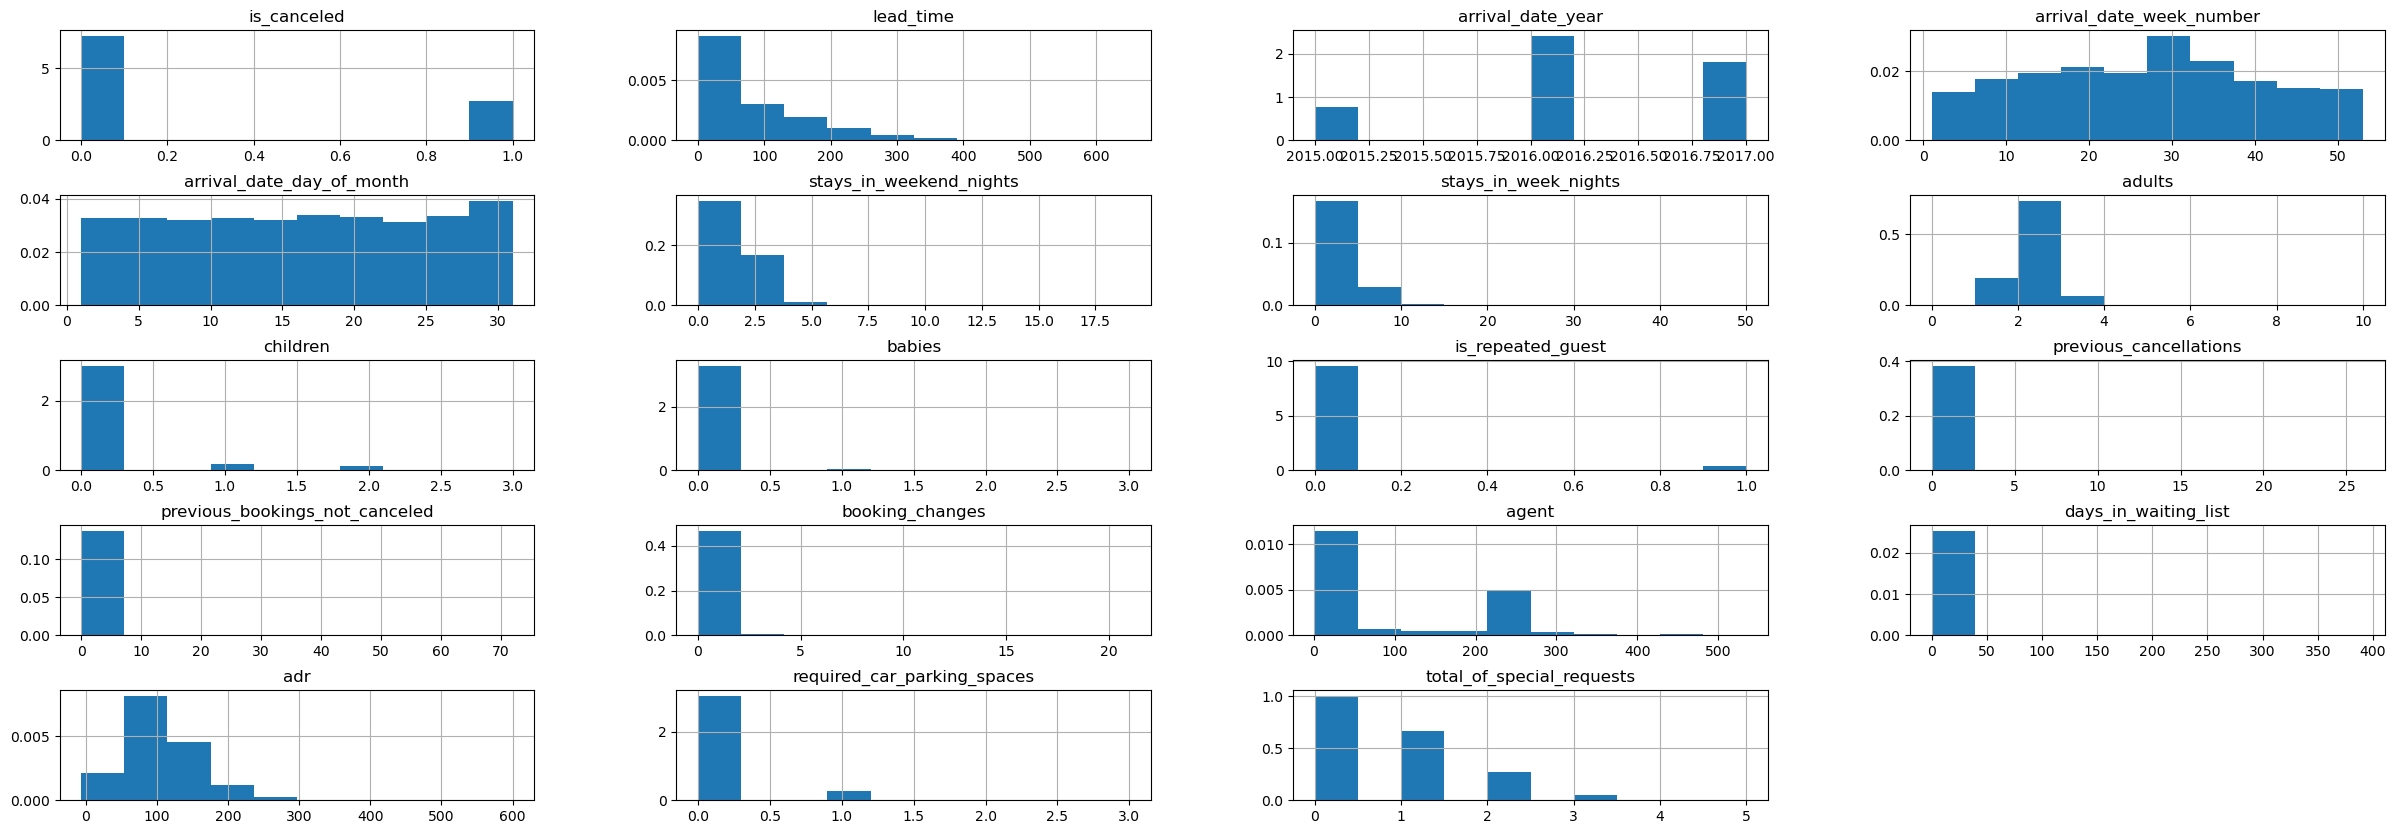

In [27]:
histPlots = data.hist(figsize=(30, 10),bins=10, density=True)
plt.subplots_adjust(hspace=.5) 

### Transformation

Here, we apply some tranformations using a data pipe. Probaby the best thing about sklearn imo

In [28]:
# Separate the data into numerical and categorical features so we can process them easily
numCols = list(data.select_dtypes(include='number').columns)
numCols.remove('is_canceled')
catCols = list(data.select_dtypes(exclude='number').columns)

print(numCols)
print(catCols)

['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']
['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status_date']


In [29]:
# Split data into training and test sets before transformations to prevent test data leakage
features = numCols + catCols
print(features)

X = data[features]
y = data['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

print(X_train.head(2))
print(y_train.head(2))

['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status_date']
       lead_time  arrival_date_year  arrival_date_week_number  arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  is_repeated_guest  ...  \
27034        251               2016                        33                          9                        2                     7       2       0.0       0                  0  ...   
26550         81               2016                

In [35]:
# Lets impute numerical variables with the median
# Categorical variables are imputed with a 'missing' tag, and one-hot encoded so we are free to choose any model
set_config(transform_output="pandas")

transform_num = Pipeline(steps=[
    ('impute_num', SimpleImputer(strategy='median')),
    ('normalize', StandardScaler())
])

transform_cat = Pipeline(steps=[
    ('impute_cat', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", transform_num, numCols),
    ("cat", transform_cat, catCols)
])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute_num',
                                                  SimpleImputer(strategy='median')),
                                                 ('normalize',
                                                  StandardScaler())]),
                                 ['lead_time', 'arrival_date_year',
                                  'arrival_date_week_number',
                                  'arrival_date_day_of_month',
                                  'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'adults', 'children',
                                  'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'pr...
                                ('cat',
                                 Pipeline(steps=[('impute_cat',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['hotel', 'arrival_date_month', 'meal',
                                  'country', 'market_segment',
                                  'distribution_channel', 'reserved_room_type',
                                  'assigned_room_type', 'deposit_type',
                                  'customer_type',
                                  'reservation_status_date'])])

### Modeling

1. Split data into training and test sets

### Fit Models and Evaluate Performance

In [36]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, plot_importance, Booster
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#### Logistic Regression

We start with Logit model. It is the easiest to interpret. May sacrifice performance for explanatory power!

c:\Users\delao\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.93      0.88     15885
           1       0.72      0.51      0.60      5962

    accuracy                           0.81     21847
   macro avg       0.78      0.72      0.74     21847
weighted avg       0.80      0.81      0.80     21847



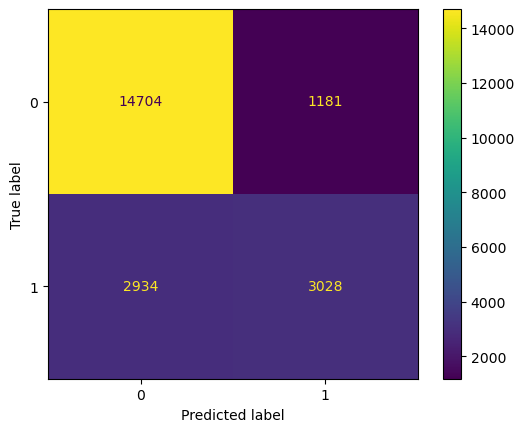

In [42]:
logit = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(solver='saga',n_jobs=-1))
])

logit.fit(X_train, y_train)


# test
y_pred = logit.predict(X_test)

# performance
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=logit.classes_)
disp.plot()

### Single Tree


              precision    recall  f1-score   support

           0       0.87      0.96      0.91     15885
           1       0.85      0.63      0.72      5962

    accuracy                           0.87     21847
   macro avg       0.86      0.79      0.82     21847
weighted avg       0.87      0.87      0.86     21847



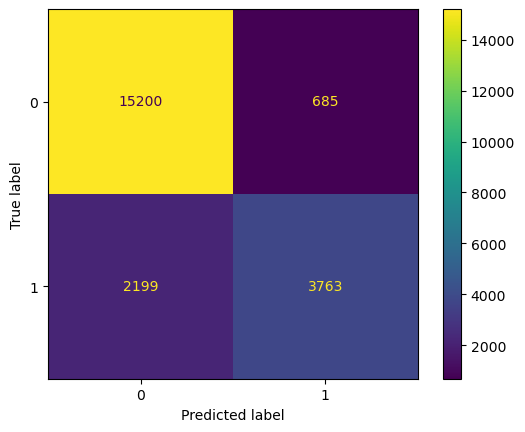

In [43]:
cTree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_jobs=-1))
])
cTree
cTree.fit(X_train, y_train)


# test
y_pred = cTree.predict(X_test)

# performance
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=cTree.classes_)
disp.plot()

### Random Forest

Can we do better? Random forest models work pretty much out of the box, and are theoretically more performant than single models (due to bagging techniques)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     15885
           1       0.84      0.63      0.72      5962

    accuracy                           0.87     21847
   macro avg       0.86      0.79      0.82     21847
weighted avg       0.86      0.87      0.86     21847



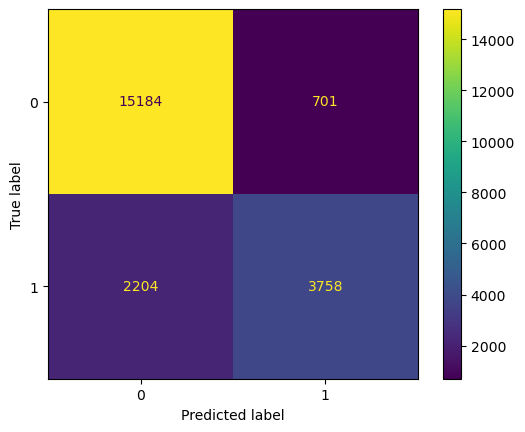

In [38]:
rForest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_jobs=-1))
])
rForest
rForest.fit(X_train, y_train)


# test
y_pred = rForest.predict(X_test)

# performance
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=rForest.classes_)
disp.plot()

### Boosted Tree

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     15885
           1       0.78      0.69      0.73      5962

    accuracy                           0.86     21847
   macro avg       0.84      0.81      0.82     21847
weighted avg       0.86      0.86      0.86     21847



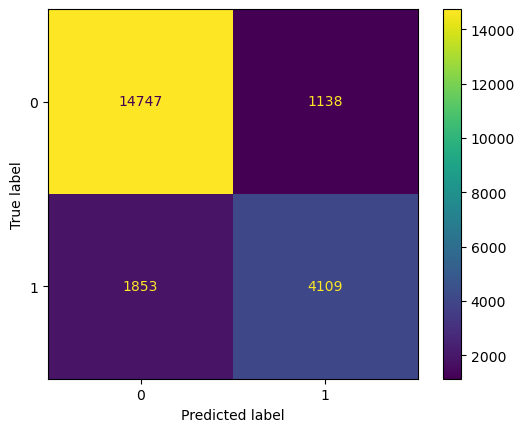

In [44]:
lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier())
])
lgbm
lgbm.fit(X_train, y_train)


# test
y_pred = lgbm.predict(X_test)

# performance
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=lgbm.classes_)
disp.plot()

### Optimize Final Model

We choose he boosted tree algorithm because even though it gets similar performance to the random forest, it is WAY faster.

For a production model, I would write a set of optimizers, but for this exercise I'll just tinker with the parmeters manually.

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     15885
           1       0.94      0.89      0.91      5962

    accuracy                           0.95     21847
   macro avg       0.95      0.93      0.94     21847
weighted avg       0.95      0.95      0.95     21847



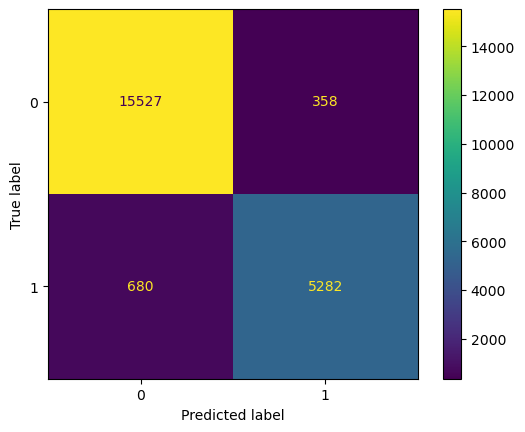

In [40]:
lgbmOpt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(learning_rate=.75, n_estimators=200, objective='binary'))
])
lgbmOpt
lgbmOpt.fit(X_train, y_train)


# test
y_pred = lgbmOpt.predict(X_test)

# performance
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=lgbmOpt.classes_)
disp.plot()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

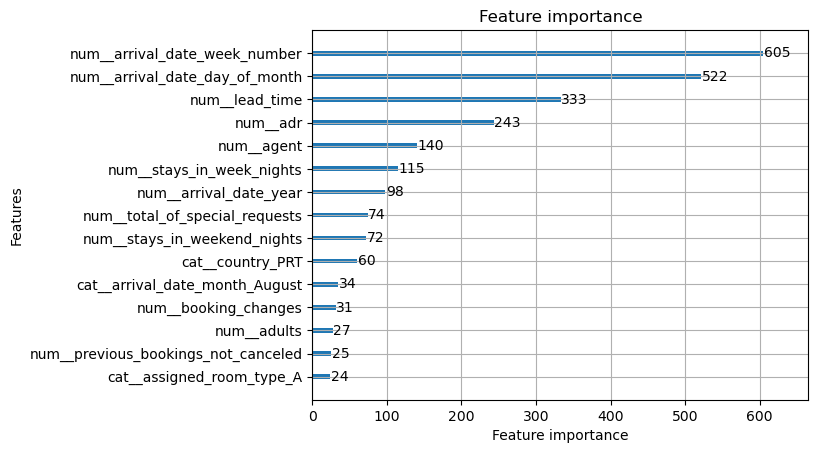

In [41]:
#feats = Booster(lgbmOpt['model']).feature_names = [features]
#print(feats)

plot_importance(lgbmOpt['model'],max_num_features=15)
